<a href="https://colab.research.google.com/github/nicoloceneda/Python-edu/blob/master/TensorFlow_Custom_Layer_and_Models_with_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow - Custom Architectures with Keras API 
---



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mlxtend.plotting import plot_decision_regions

## Data creation

## Keras model class
Besides allowing to build neural networks with common architectures, the Keras API also allows to build more complex and customized models. This is shown by re-running the **XOR classification task** presented in the subsection "Example of Keras object oriented API" of the module "TensorFlow - Common Architectures with Keras API"

We start by recreating the dataset.

In [0]:
tf.random.set_seed(seed=1)
np.random.seed(seed=1)

# Generating the features
x = np.random.uniform(low=-1, high=1, size=(200, 2))

# Generating the class labels  
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

# Splitting into training and validation datasets
x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

# Plotting the dataset
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], 'o', alpha=0.75, markersize=10)
plt.xlabel('$x_0$', size=15)
plt.ylabel('$x_1$', size=15)
plt.show()

1. We can **build a customized model**, by subclassing the `tf.keras.Model` class
2. We can **create the layers**, in the constructor `__init__` method:
3. We can **create the forward pass**, using the `call` method

In [0]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
    self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
    self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
    self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
    
  def call(self, inputs):
    h = self.hidden_1(inputs)
    h = self.hidden_2(h)
    h = self.hidden_3(h)
    return self.output_layer(h)

4. We can **create an instance** of the medel
5. We can **create the variables**, using the `build` method 

In [0]:
model = MyModel()

model.build(input_shape=(None, 2))
model.summary()

6. We **configure the model** when we compile it, using `tf.keras.optimizers`, `tf.keras.losses`, `tf.keras.metrics`


In [0]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

7. We **train the model** for 200 epochs with a batch size of 2, using the `fit` method

In [0]:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  12        
_________________________________________________________________
dense_1 (Dense)              multiple                  20        
_________________________________________________________________
dense_2 (Dense)              multiple                  20        
_________________________________________________________________
dense_3 (Dense)              multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


## Keras layer class
If we want to define a new layer that is not already supported by Keras, we can define a new class by subclassing the `tf.keras.layers.Layer` class. This is especially useful when designing a new layer or customizing an existing layer. 

Imagine we want to define a new linear layer that computes $w(x + \epsilon) + b$ where $\epsilon$ is a random noise.

1. We create the `__init__` method: here, we define **required tensors** other than variables (if any)
2. We create the `build` method: here, we define the **variables** (late variable ceation)
3. We create the `call` method: here, we define the **forward pass** of the neural network.
4. We create the `get_config` method: this is used for **serialization** and allows to save and load a model using the defined custom layers

In [0]:
class NoisyLinear(tf.keras.layers.Layer):

  def __init__(self, output_dim, noise_stddev, **kwargs):
    super(NoisyLinear, self).__init__(**kwargs)
    self.output_dim = output_dim
    self.noise_stddev = noise_stddev
  
  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[1], self.output_dim),initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.output_dim, ), initializer='zeros', trainable=True)

  def call(self, inputs, training=False):
    if training:
      batch = tf.shape(inputs)[0]
      dim = tf.shape(inputs)[1]
      noise = tf.random.normal(shape=(batch, dim), mean=0.0, stddev=self.noise_stddev)
      noisy_inputs = tf.add(inputs, noise)
    else:
      noisy_inputs = inputs
    z = tf.matmul(noisy_inputs, self.w) + self.b
    return tf.keras.activations.relu(z)

  def get_config(self):
    config = super(NoisyLinear, self).get_config()
    config.update({'output_dim': self.output_dim, 'noise_stddev': self.noise_stddev})
    return config
    

Before using the custom layer in a model, let's test in in a simple example

In [0]:
tf.random.set_seed(seed=1)

x = tf.zeros(shape=(1, 4))

# We define a new instance of the layer
noisy_layer = NoisyLinear(output_dim=4, noise_stddev=0.1)
# We initialize the instance
noisy_layer.build(input_shape=(None, 4))
# We execute the instance on an input tensor
tf.print(noisy_layer(x, training=True))

[[0 0.00821428 0 0]]


In [0]:
# We serialize the instance 
config = noisy_layer.get_config()
# We restore the serialized object 
new_layer = NoisyLinear.from_config(config)
# # We execute the instance on an input tensor
tf.print(new_layer(x, training=True))

[[0 0.0108502861 0 0]]


We create a new model for solving a XOR classification task: we still use the Sequential class but with the newly created NoisyLinear layer.

In [0]:
tf.random.set_seed(seed=1)

model = tf.keras.Sequential()
model.add(NoisyLinear(output_dim=4, noise_stddev=0.1))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_1 (NoisyLinear) multiple                  12        
_________________________________________________________________
dense_4 (Dense)              multiple                  20        
_________________________________________________________________
dense_5 (Dense)              multiple                  20        
_________________________________________________________________
dense_6 (Dense)              multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [0]:
# We compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# We train the model
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


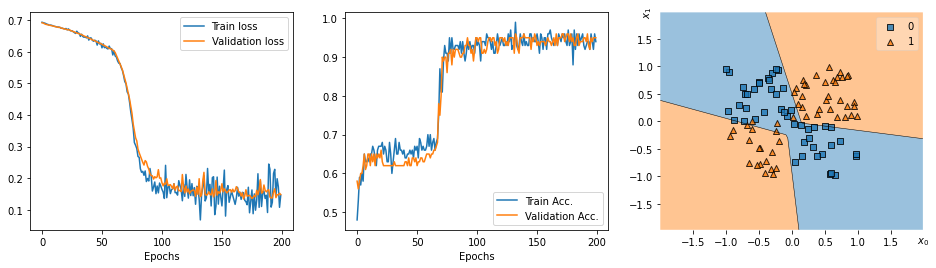

In [0]:
# Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'])
plt.plot(history['val_binary_accuracy'])
plt.legend(['Train Acc.', 'Validation Acc.'])
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
ax.set_xlabel('$x_0$')
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel('$x_1$')
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### Call method
The call method can take the additional argument `training`, which is a special Boolean argument that distinguishes whether a model or layer is used during training (via `fit()`) or only for prediction (via `predict()`). The main difference between training and prediction is that, during the latter, we do not require gradients. Moreover, there are certain methods that behave differently in training and prediction models. 

### Adding weights
**Add trainable weights** to a layer `manually` or using `add_weight` in the `__init__` method

In [0]:
# Using add_weight (preferred)
class Linear(layers.Layer):

  def __init__(self, units=32, input_dim=32):
    super(Linear, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(units, ), initializer='zeros', trainable=True)

  def call(self, inputs):
    return tf.linalg.matmul(inputs, self.w) + self.b

  x = tf.ones((2, 2))

  linear_layer = Linear(units=4, input_dim=2)
  y = linear_layer(inputs=x)
  tf.print(y)

NameError: ignored

In [0]:
# Manually
class Linear(layers.Layer):

  def __init__(self, units=32, input_dim=32):
    super(Linear, self).__init__()
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units), dtype='float32'), trainable=True)
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(initial_value=b_init(shape=(units, ), dtype='float32'), trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2, 2))

linear_layer = Linear(units=4, input_dim=2)
y = linear_layer(inputs=x)
tf.print(y)

**Add non-trainable weights** (which are meant not to be taken into account during the backpropagation process of training) to a Layer `manually`. 

In [0]:
class ComputeSum(layers.Layer):

  def __init__(self, input_dim=32):
    super(ComputeSum, self).__init__()
    self.total = tf.Variable(initial_value=tf.zeros((input_dim, )), trainable=False)

  def call(self, inputs):
    self.total.assign_add(tf.reduce_sum(inputs, axis=0))
    return self.total

x = tf.ones((2, 2))

my_sum = ComputeSum(input_dim=2)
y = my_sum(inputs=x)
tf.print(y)
y = my_sum(inputs=x)
tf.print(y)

**variables** if the `input_shape` is given; if we do not know the input shape upfront, we must do late variable ceation, i.e. initialize the variable in the build method 

**Defer weight creation** until the shape of the inputs is known using `add_weight` in the `build` method. Doing so, the weights are created dynamically the first time the layer is called. This is the best practice as in many cases the size of the inputs is not known in advance.

In [0]:
class Linear(layers.Layer):

  def __init__(self, units=32):
    super(Linear, self).__init__()
    self.units = units

  def build(self, input_shape=32):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.units, ), initializer='zeros', trainable=True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2, 2))

linear_layer = Linear(units=4)
y = linear_layer(inputs=x)
tf.print(y)

Define **layers recursively** (a layer instance is assigned as attribute of another layer) by instantiating them in the `__init__` method.

In [0]:
class Linear(layers.Layer):

  def __init__(self, units=32):
    super(Linear, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.units, ), initializer='zeros', trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MLPBlock(layers.Layer):

  def __init__(self):
    super(MLPBlock, self).__init__()
    self.linear_1 = Linear(units=32)
    self.linear_2 = Linear(units=32)
    self.linear_3 = Linear(units=1)

  def call(self, inputs):
    x = self.linear_1(inputs)
    x = tf.nn.relu(x)
    x = self.linear_2(x)
    x = tf.nn.relu(x)
    return self.linear_3(x)

x = tf.ones(shape=(3, 64))

mlp = MLPBlock()
y = mlp(inputs=x)
tf.print(y)

## Adding losses

**Add a loss** tensor using `add_loss` in the `call` method

In [0]:
class ActivityRegularizationLayer(layers.Layer):

  def __init__(self, rate=1e-2):
    super(ActivityRegularizationLayer, self).__init__()
    self.rate = rate 

  def call(self, inputs):
    self.add_loss(self.rate * tf.math.reduce_sum(inputs))
    return inputs

**Retrieve the loss** using `layer.losses` (this property is reset at the start of every call to the top-level layer, so that it always contains the loss created during the last forward pass). 

In [0]:
class ActivityRegularizationLayer(layers.Layer):

  def __init__(self, rate=1e-2):
    super(ActivityRegularizationLayer, self).__init__()
    self.rate = rate 

  def call(self, inputs):
    self.add_loss(self.rate * tf.math.reduce_sum(inputs))
    return inputs

class OuterLayer(layers.Layer):

  def __init__(self):
    super(OuterLayer, self).__init__()
    self.activity_reg = ActivityRegularizationLayer(rate=1e-2)

  def call(self, inputs):
    return self.activity_reg(inputs)

x = tf.zeros(1, 1)

layer = OuterLayer()
assert len(layer.losses) == 0  # No losses yet since the layer has never been called
_ = layer(x)
assert len(layer.losses) == 1  # We created one loss value
_ = layer(x)
assert len(layer.losses) == 1  # This is the loss created during the call above

## Serializing layers
**Serialize layers** (recreate a layer from its configuration, as part of a functional model) using `get_config`

In [0]:
class Linear(layers.Layer):

  def __init__(self, units=32):
    super(Linear, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.units, ), initializer='zeros', traibale=True)

  def call(self, inputs):
    return tf.linalg.matmul(inputs, self.w) + self.build

  def get_config(self):
    return {'units': self.units}

layer = Linear(units=64)
config = layer.get_config()
print(config)

new_layer = Linear.from_config(config)

The `__init__` method of the base Layer class takes some keyword arguments, in particular a `name` and a `dtype`. It is best practuce to pass these **keyword arguments** to the parent class in `__init__` and include them in the layer config.

In [0]:
class Linear(layers.Layer):

  def __init__(self, units=32, **kwargs):
    super(Linear, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.units, ), initializer='random_normal', trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

  def get_config(self):
    config = super(Linear, self).get_config()
    config.update({'units': self.units})
    return config


layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

## Model class
To summarize the Layer class:
* A Layer encapsulates a state (in the `build` method) and some computation (in the `call` method)
* Layers can create (in the `call` method) and track losses
* Layers can be recursively nested to create bigger computation blocks


While the Layer class is used to define inner computation blocks, the Model class is used to define the outer model, i.e. the object to be trained. The Model class has the same API as Layer, with the following differences:
* It exposes built-in training (`model.fit`), evaluation (`model.evaluate`), and predicion loops (`model.predict`)
* It exposes the list of its inner layers (`model.layers`)
* It exposes saving (`model.save_weights`) and serialization APIs